# Process Bigraph Diagrams for Tumor-Tcell ABM

In [96]:
import copy
from bigraph_viz import plot_bigraph, plot_multitimestep, convert_vivarium_composite
from bigraph_viz.dict_utils import replace_regex_recursive
from tumor_tcell.experiments.main import large_experiment
from vivarium.core.engine import pf
from vivarium.core.composer import Composite

plot_settings = {}
save_images = False
if save_images:
    plot_settings.update({'out_dir': 'out','dpi': '250'})
    
plot_settings2={}
if save_images:
    plot_settings2.update({
        'out_dir': 'out',
        'dpi': '250'
    })

def get_in(dict, path):
    if path:
        dict = get_in(dict[path[0]], path[1:]) 
    return dict

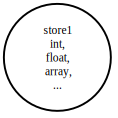

In [97]:
typed_store_spec = {
    'store1': {
        '_value': 'int, float, array, ...'}}

# plot
plot_bigraph(replace_regex_recursive(typed_store_spec), **plot_settings, show_values=True, show_types=True, filename='store')

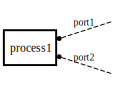

In [98]:
process_spec = {
    '_type': 'python_process',
    'process1': {
        '_type': 'edge',
        '_ports': {
            'port1': 'Any',
            'port2': 'Any'}}}

# plot
plot_bigraph(process_spec, **plot_settings, rankdir='RL', filename='process')

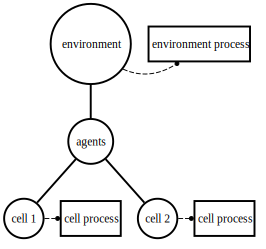

In [99]:
agent_spec = {
    'cell process': {
        'wires': {
            'port1': [],}}}

abm_spec = {
    'environment': {
        'agents': {
            'cell 1': agent_spec,
            'cell 2': agent_spec}},
    'environment process': {
        'wires': {
            'port1': 'environment'}}}

# plot
node_groups = [
    [('environment',), ('environment process',)],
    [('environment', 'agents', 'cell 1'), ('environment', 'agents', 'cell 1', 'cell process',)],
    [('environment', 'agents', 'cell 2'), ('environment', 'agents', 'cell 2', 'cell process',)],
]
plot_bigraph(abm_spec, **plot_settings, node_groups=node_groups, port_labels=False, remove_process_place_edges=True, filename='abm_composite')

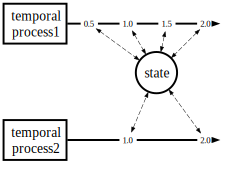

In [100]:
multitimestep_spec = {
    'temporal process2': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 1.0,
    },
    'temporal process1': {
        '_ports': {'port1': 'Any'},
        'wires': {'port1': 'state'},
        '_sync_step': 0.5,
    },
}
multitimestep_spec = replace_regex_recursive(multitimestep_spec)
plot_multitimestep(multitimestep_spec, total_time=2.0, **plot_settings2, filename='multitimestep')

## Full ABM

In [101]:
# get the experiment
data, experiment = large_experiment(
        n_tcells=1,
        n_tumors=1,
        n_dendritic=1,
        n_tcells_lymph_node=0,
        tumors_state_PDL1n=0.5,
        tcells_total_PD1n=8,
        dendritic_state_active=0.5,
        lymph_nodes=True,
        total_time=0, 
        field_molecules=['IFNg', 'tumor_debris'],
        return_experiment=True,
    )

# make a composite from the experiment
composite = Composite(
    state=experiment.state.get_value(), 
    processes=experiment.state.get_processes(), 
    steps=experiment.state.get_steps(), 
    topology=experiment.state.get_topology(), 
    flow=experiment.state.get_flow(),
)
del composite['_schema']
del composite['state']

# convert to a bigraph spec for visualization
abm_experiment_spec = convert_vivarium_composite(composite)

Initializing experiment tumor_tcell_20231018.085645


0it [00:00, ?it/s]

Completed in 0.00 seconds


In [102]:
# tidy up
lymph_node_transfer = {'lymph_node_transfer': {'wires': experiment.state.get_value()['lymph_node_transfer'][1]}}
abm_experiment_spec.update(lymph_node_transfer)
del abm_experiment_spec['tumor_environment']['death_log']
del abm_experiment_spec['tumor_environment']['log']
del abm_experiment_spec['tumor_environment']['clock']
del abm_experiment_spec['tumor_environment']['global_time']

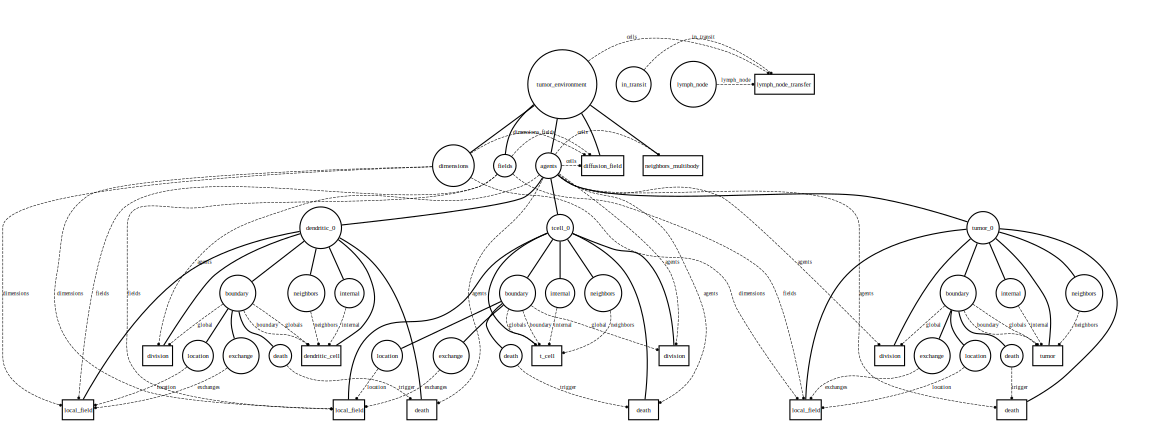

In [103]:
# plot full bigraph
node_groups = [
    [
        ('tumor_environment',), 
        ('in_transit',), ('lymph_node',), 
        ('lymph_node_transfer',)],
    [
        ('tumor_environment', 'dimensions',), 
        ('tumor_environment', 'fields',), 
        ('tumor_environment', 'agents',), 
        ('tumor_environment', 'diffusion_field',), 
        ('tumor_environment', 'neighbors_multibody',), 
    ],
]
plot_bigraph(abm_experiment_spec, 
             **plot_settings,
             node_groups=node_groups,
             filename='abm_experiment',
            )

## Environment composite

In [104]:
tumor_environment_spec = copy.deepcopy(abm_experiment_spec['tumor_environment'])
tumor_agents_spec = copy.deepcopy(abm_experiment_spec['tumor_environment']['agents'])
tumor_environment_spec['agents'] = {}

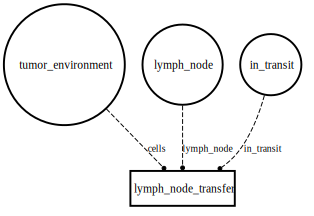

In [105]:
plot_bigraph(lymph_node_transfer, 
             **plot_settings,
             filename='lymph_node_transfer',
            )

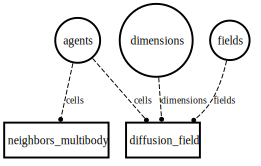

In [106]:
plot_bigraph(tumor_environment_spec, 
             **plot_settings,
             filename='tumor_environment',
            )

## Cell Agent composites

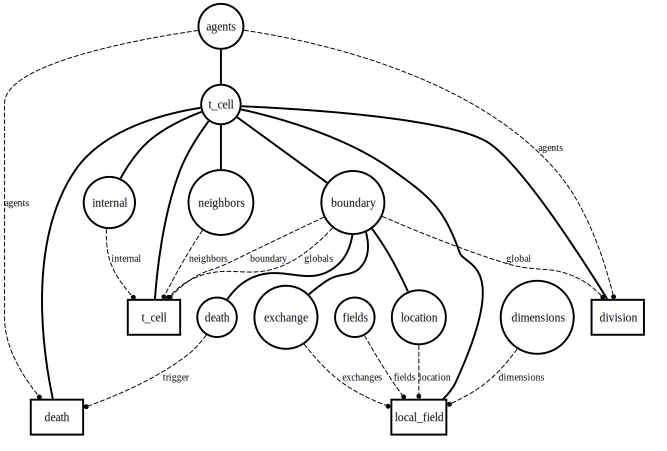

In [107]:
plot_bigraph({'agents': {'t_cell': tumor_agents_spec['tcell_0']}}, 
             **plot_settings,
             filename='tcell_composite',
            )

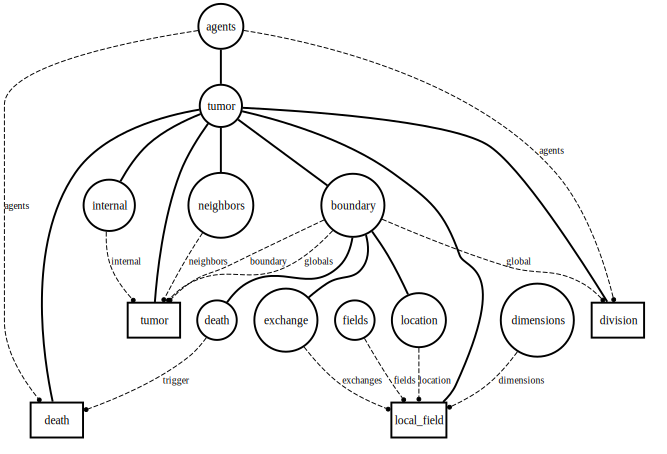

In [108]:
plot_bigraph({'agents': {'tumor': tumor_agents_spec['tumor_0']}}, 
             **plot_settings,
             filename='tumor_composite',
            )

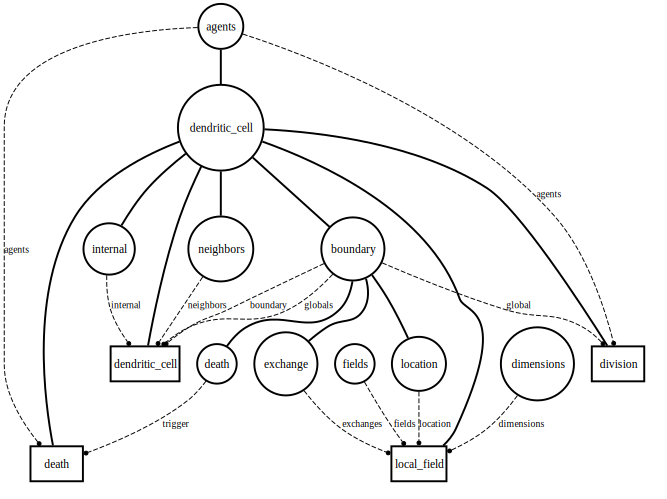

In [109]:
plot_bigraph({'agents': {'dendritic_cell': tumor_agents_spec['dendritic_0']}}, 
             **plot_settings,
             filename='dendritic_composite',
            )

## Stand-alone processes

In [110]:
topology = composite['topology']
tcell_topology = get_in(topology, ['tumor_environment', 'agents', 'tcell_0'])
tumor_topology = get_in(topology, ['tumor_environment', 'agents', 'tumor_0'])
dendritic_topology = get_in(topology, ['tumor_environment', 'agents', 'dendritic_0'])
neighbors_topology = get_in(topology, ['tumor_environment', 'neighbors_multibody'])
diffusion_topology = get_in(topology, ['tumor_environment', 'diffusion_field'])
lymph_node_transfer_topology = get_in(topology, ['lymph_node_transfer'])

### Cell Processes

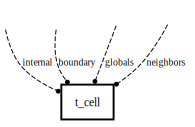

In [111]:
t_cell_spec = {'t_cell': {'_ports': tcell_topology['t_cell']}}
plot_bigraph(t_cell_spec, **plot_settings, filename='tcell_process')

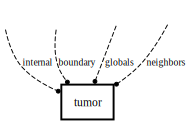

In [112]:
tumor_spec = {'tumor': {'_ports': tumor_topology['tumor']}}
plot_bigraph(tumor_spec, **plot_settings, filename='tumor_process')

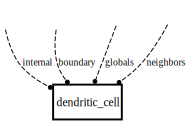

In [113]:
dendritic_spec = {'dendritic_cell': {'_ports': dendritic_topology['dendritic_cell']}}
plot_bigraph(dendritic_spec, **plot_settings, filename='dendritic_process')

### Adapter processes

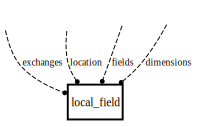

In [114]:
local_field_spec = {'local_field': {'_ports': tcell_topology['local_field']}}
plot_bigraph(local_field_spec, **plot_settings, filename='local_field_process')

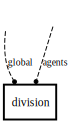

In [115]:
division_spec = {'division': {'_ports': tcell_topology['division']}}
plot_bigraph(division_spec, **plot_settings, filename='division_process')

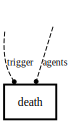

In [116]:
death_spec = {'death': {'_ports': tcell_topology['death']}}
plot_bigraph(death_spec, **plot_settings, filename='death_process')

### Environment processes

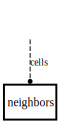

In [117]:
neighbors_spec = {'neighbors': {'_ports': neighbors_topology}}
plot_bigraph(neighbors_spec, **plot_settings, filename='neighbors_process')

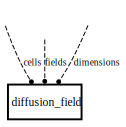

In [118]:
diffusion_spec = {'diffusion_field': {'_ports': diffusion_topology}}
plot_bigraph(diffusion_spec, **plot_settings, filename='diffusion_process')

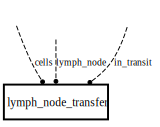

In [119]:
lymph_node_transfer_spec = {'lymph_node_transfer': {'_ports': lymph_node_transfer_topology}}
plot_bigraph(lymph_node_transfer_spec, **plot_settings, filename='lymph_node_transfer_process')